In [1]:
from sklearn.decomposition import PCA
from Data.load import load
import numpy as np
from matplotlib import pyplot as plt

In [2]:
train = load(take=-1, train_test_split=1)
train.shape

Loading images: 100%|██████████| 496/496 [04:17<00:00,  1.92it/s]


(496, 80, 96, 80)

In [6]:
def wnd_from(train,stride=3,wndlen=8):
    windows = []
    for i in range(0,train.shape[1]-wndlen,stride):
        for j in range(0,train.shape[2]-wndlen,stride):
            for k in range(0,train.shape[3]-wndlen,stride):
                for img_idx in range(len(train)):
                    wnd = train[img_idx, i:i+wndlen, j:j+wndlen, k:k+wndlen]
                    windows.append(wnd)

    return np.stack([w.flatten() for w in windows])

wndlen = 4
windows = wnd_from(train[:60],wndlen=wndlen)
windows.shape

(1257360, 64)

In [7]:
pca = PCA(17)
windows1 = pca.fit_transform(np.stack([w.flatten() for w in windows]))
np.sum(pca.explained_variance_ratio_)

0.9901885771925402

In [8]:
def apply_pca(pca, img):
    img_pca = []
    r=wndlen#//2
    for i in range(0,img.shape[0],r):
        img_1 = []
        for j in range(0,img.shape[1],r):
            img_2 = []
            for k in range(0,img.shape[2],r):
                wnd = img[i:i+wndlen, j:j+wndlen, k:k+wndlen].flatten()
                if len(wnd)==0:
                    print(i,j,k)
                    continue
                img_2.append(pca.transform(wnd.reshape(1,-1))[0])
            img_1.append(img_2)
        img_pca.append(img_1)
    img_pca = np.array(img_pca)
    return img_pca

img_pca = apply_pca(pca, train[0])
img_pca.shape # 26 730

(20, 24, 20, 17)

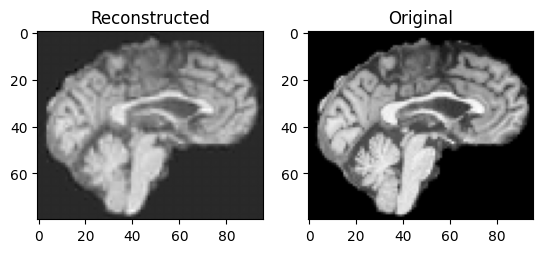

In [9]:
def reconstruct_img(img_pca, pca, output_shape,depth=1):
    reconstructed_img = np.zeros(output_shape)
    r=wndlen#//2
    for i in range(img_pca.shape[0]):
        for j in range(img_pca.shape[1]):
            for k in range(img_pca.shape[2]):
                wnd_reconstructed = pca.inverse_transform(img_pca[i,j,k])
                if depth==1:
                    wnd_reconstructed = wnd_reconstructed.reshape(wndlen, wndlen, wndlen)
                else:
                    wnd_reconstructed = wnd_reconstructed.reshape(wndlen, wndlen, wndlen,depth)
                reconstructed_img[i*r:i*r+wndlen, j*r:j*r+wndlen, k*r:k*r+wndlen] += wnd_reconstructed  # Place it back
    return reconstructed_img

img_idx = 2
img_pca = apply_pca(pca, train[img_idx])
reconstructed_img = reconstruct_img(img_pca,pca,train[img_idx].shape)
# Display the reconstructed image
def plot_two(recon, ori):
    plt.subplot(1,2,1)
    plt.imshow(np.rot90(recon[train.shape[1]//2,:, :]), cmap='gray')  # Display middle slice
    plt.title("Reconstructed")

    plt.subplot(1,2,2)
    plt.imshow(np.rot90(ori[train.shape[1]//2,:, :]), cmap='gray')  # Display middle slice
    plt.title("Original")
plot_two(reconstructed_img, train[img_idx])

In [10]:
windows1=[]
wndlen = 4
for img_idx in range(50):
    img_pca = apply_pca(pca, train[img_idx])
    windows1.extend(wnd_from(np.array([img_pca]),wndlen=wndlen))
windows1 = np.stack(windows1)
windows1.shape

(12600, 1088)

In [13]:
pca1 = PCA(300)
pca1.fit_transform(np.stack([w.flatten() for w in windows1]))
np.sum(pca1.explained_variance_ratio_)

0.9858415876388504

Input shape to PCA: (5, 6, 5, 300) latent dims 45000


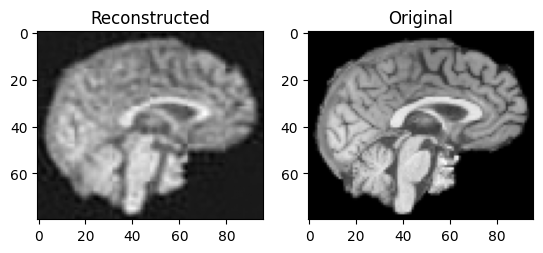

In [14]:
img_idx=7
img_pca = apply_pca(pca, train[img_idx])
img_pca1 = apply_pca(pca1, img_pca)
print("Input shape to PCA:",img_pca1.shape,f"latent dims {np.prod(img_pca1.shape)}")
reconstructed_img_pca = reconstruct_img(img_pca1,pca1,img_pca.shape,17)
reconstructed_img = reconstruct_img(reconstructed_img_pca,pca,train[0].shape)

plot_two(reconstructed_img, train[img_idx])

In [ ]:
from tqdm import tqdm

pca_train = []
for i in tqdm(range(len(train)),"Applying PCA"):
    im = train[i]
    img_pca = apply_pca(pca, im)
    img_pca1 = apply_pca(pca1, img_pca)
    pca_train.append(img_pca1)

pca_train = np.stack(pca_train)
print("Output shape:", pca_train.shape)

path = "Data/pca_images.npy"
np.save(open(path,"wb"),pca_train)
print(f"Saved to {path}")

Applying PCA: 100%|██████████| 496/496 [02:23<00:00,  3.46it/s]

Output shape: (496, 5, 6, 5, 300)


AttributeError: 'numpy.ndarray' object has no attribute 'save'

The cells below are used for training on the difference to the mean brain

In [3]:
# mean_brain = np.mean(train, axis=0)
# train_diff = train - mean_brain
# plt.imshow(np.rot90(train_diff[0,mean_brain.shape[0]//2]))

Input shape to PCA: (5, 6, 5, 200) latent dims 30000


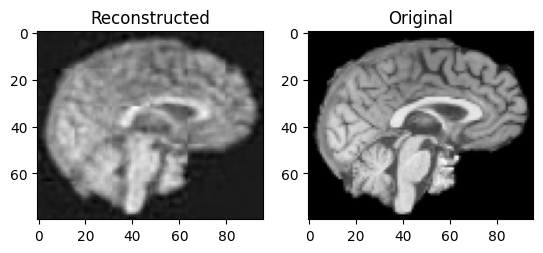

In [ ]:
img_idx=7
img_pca = apply_pca(pca, train_diff[img_idx])
img_pca1 = apply_pca(pca1, img_pca)
print("Input shape to PCA:",img_pca1.shape,f"latent dims {np.prod(img_pca1.shape)}")
reconstructed_img_pca = reconstruct_img(img_pca1,pca1,img_pca.shape,17)
reconstructed_img = reconstruct_img(reconstructed_img_pca,pca,train[0].shape)

plot_two(reconstructed_img+mean_brain, train_diff[img_idx]+mean_brain)

Input shape to PCA: (5, 6, 5, 200) latent dims 30000


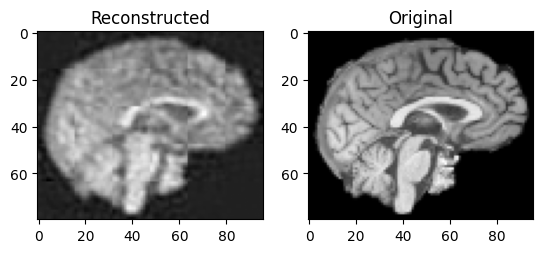

In [ ]:
img_idx=7
# Same script as above but here we add back in the mean brain BEFORE pca upscaling and get same results
img_pca = apply_pca(pca, train_diff[img_idx]+mean_brain)
img_pca1 = apply_pca(pca1, img_pca)
print("Input shape to PCA:",img_pca1.shape,f"latent dims {np.prod(img_pca1.shape)}")
reconstructed_img_pca = reconstruct_img(img_pca1,pca1,img_pca.shape,17)
reconstructed_img = reconstruct_img(reconstructed_img_pca,pca,train[0].shape)

plot_two(reconstructed_img, train_diff[img_idx]+mean_brain)

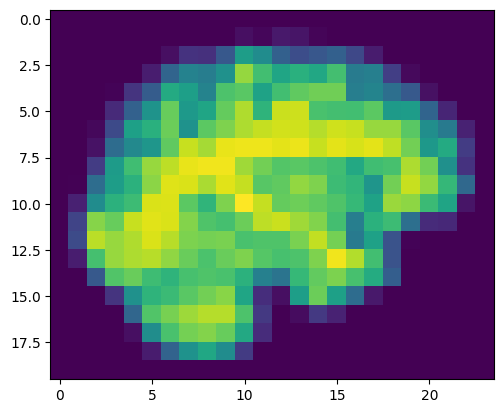

In [268]:
from matplotlib import pyplot as plt
plt.imshow(np.rot90(img_pca[5,:,:,0]))

In [88]:
from tensorflow.keras import layers, Model, activations

input_shape = list(windows.shape[1:])+[1]
# Encoder
encoder_input = x = layers.Input(shape=input_shape)
x = layers.Conv3D(4, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3D(10, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
pre_flatten_shape = x.shape
print(f"Pre-flattened latent shape: {pre_flatten_shape}")
x = layers.Flatten()(x)
encoded = layers.Dense(20, activation="relu")(x)
encoder = Model(encoder_input, encoded, name="encoder")

# Decoder
decoder_input = x = layers.Input(shape=encoded.shape[1:])  # Adjusted latent space shape

# Reshape back to 3D
x = layers.Dense(
    pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4],
    activation="relu"
)(decoder_input)
x = layers.Reshape(pre_flatten_shape[1:])(x)
x = layers.Conv3DTranspose(10, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3DTranspose(4, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)
decoder = Model(decoder_input, decoded, name="decoder")

# Full Autoencoder (combine encoder and decoder)
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

autoencoder.fit(windows,windows,epochs=5,verbose=True,batch_size=64)

Pre-flattened latent shape: (None, 2, 2, 2, 10)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 8, 8, 8, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 20)             │         2,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 8, 8, 8, 1)     │         5,583 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,405 (32.83 KB)

 Trainable params: 8,405 (32.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0109
Epoch 2/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0022
Epoch 3/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 4/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 5/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0018


In [92]:
import numpy as np

# Get autoencoder output (reconstructed data)
x_reconstructed = autoencoder.predict(windows)

# Compute total variance of original data
total_variance = np.var(windows)

# Compute reconstruction variance (MSE between x and x_reconstructed)
reconstruction_variance = np.mean((windows - x_reconstructed.reshape(345600,8,8,8)) ** 2)

# Compute retained variance
retained_variance = 1 - (reconstruction_variance / total_variance)

print(f"Retained Variance: {retained_variance:.4f}")


10800/10800 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Retained Variance: 0.9509
